# Library & I/O

In [2]:
from sklearn.experimental import enable_hist_gradient_boosting

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import time

from sklearn import neural_network, neighbors, feature_extraction, datasets, linear_model, metrics, model_selection, preprocessing, svm, ensemble, decomposition, feature_extraction, utils

# Configs
%config InlineBackend.figure_format ='retina'
%matplotlib inline

# Cython
%load_ext Cython
#!python
#cython: language_level=3

print("All libraries set-up and ready to go!")

All libraries set-up and ready to go!


In [4]:
np.set_printoptions(edgeitems=10)

In [5]:
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
f = open("d.txt", "r")
deals = f.read().split("\n")
del deals[-1]
df = pd.DataFrame(data=deals, columns=['text'])
f.close

<function TextIOWrapper.close()>

# Feature construction in Pandas

In [53]:
def HCP(x):
    if x == 'A':
        return 4
    if x == 'K':
        return 3
    if x == 'Q':
        return 2
    if x == 'J':
        return 1
    return 0

def decodeHex(x):
    if x == 'A':
        return 10
    if x == 'B':
        return 11
    if x == 'C':
        return 12
    if x == 'D':
        return 13
    return x

def encodeHex(x):
    x = int(x)
    if x == 10:
        return 'A'
    if x == 11:
        return 'B'
    if x == 12:
        return 'C'
    if x == 13:
        return 'D'
    return str(x)

def roundPrediction(x):
    if x < 0.5:
        return 0
    if x > 12.5:
        return 13
    return int(x + 0.5)

def countWinners(x, pl, s):
    return 13 - int(decodeHex(x[70 + 4*s + pl]))
    
def countHCP(x, pl):
    r = 0
    for c in x[2 + 17*pl:18 + 17 * pl]:
        r += HCP(c)
    return r

def countDist(x, pl):
    r = ''
    for c in x[2 + 17*pl:18 + 17 * pl].split('.'):
        r += encodeHex(len(c))
    return r

def isBal(x, pl):
    r = ''
    for c in sorted(countDist(x, pl), reverse=True):
        r += c
    if r in ['4333', '4432']:
        return 3
    if r in ['5332', '4441', '5422']:
        return 2
    if r in ['6322', '5431']:
        return 1
    return 0

def LTC(x, pl):
    ltc = 13
    for c in x[2 + 17*pl:18 + 17 * pl].split('.'):
        if 'A' in c:
            ltc -= 1
        if (len(c) >= 2) and ('K' in c):
            ltc -= 0.75
        if (len(c) >= 2) and ('Q' in c):
            ltc -= 0.5
        if (len(c) >= 3) and ('J' in c):
            ltc -= 0.25        
        if (len(c) >= 4):
            ltc -= 0.5
        if (len(c) >= 5):
            ltc -= len(c) - 4
    return ltc

def contains(x, pl, c):
    return x[2 + 17*pl:18 + 17 * pl].count(c)

In [60]:
for i in range(0, 4):
    df['HCP' + str(i)] = df['text'].apply(func=countHCP, args=(i,))
    df['LTC' + str(i)] = df['text'].apply(func=LTC, args=(i,))
    df['Bal' + str(i)] = df['text'].apply(func=isBal, args=(i,))
    #df['Dist' + str(i)] = df['text'].apply(func=countDist, args=(i,))
    for c in 'AKQJT':
        df['no' + c + str(i)] = df['text'].apply(func=contains, args=(i,c,))

df['HCPNS'] = df['HCP0'] + df['HCP2']
df['BalNS'] = df['Bal0'] + df['Bal2']

honorcounts = ['no' + c1 + c2 for c1 in 'AKQJT' for c2 in '0123']

df['y'] = df['text'].apply(countWinners, args=(0, 0, ))

In [55]:
df.head(3)

,text,HCP0,LTC0,Bal0,noA0,noK0,noQ0,noJ0,noT0,HCP1,...,LTC3,Bal3,noA3,noK3,noQ3,noJ3,noT3,HCPNS,BalNS,y
0,N:AKJ852.AKT3..KT9 T3.Q62.5.AQJ8763 Q764.98754...,18,5.50,0,2,3,0,1,2,9,...,6.25,0,1,1,1,1,1,21,0,0
1,N:A7542.T98743.K.6 KQJ.A.T7432.KT84 T63.Q6.AJ9...,7,8.00,0,1,1,0,0,1,13,...,9.00,3,1,1,2,1,0,15,3,3
2,N:8.K7654.K852.KT8 KQ76.AT2.3.AJ542 AJT932.Q.A...,9,8.75,1,0,3,0,0,1,14,...,11.00,3,0,0,1,2,1,22,1,7


# Running and comparing models

In [1]:
time_par = 1 #in secondi / len(models) / len(features) (approx.)

models = [(linear_model.LinearRegression(), "LinearReg."),
          (ensemble.RandomForestClassifier(n_estimators=100*time_par), "RForest   "),
          (ensemble.ExtraTreesClassifier(n_estimators=100*time_par), "ExtraTrees"),
          (ensemble.AdaBoostClassifier(n_estimators=40*time_par, learning_rate=1.25/time_par), "AdaBoostCl"),
          (ensemble.GradientBoostingClassifier(n_estimators=5*time_par), "GrBoostCl "),
          (ensemble.HistGradientBoostingClassifier(max_iter=10*time_par), "HistBoostC"),
          (neighbors.KNeighborsClassifier(n_neighbors=20), "k-NClass  "),
          (neural_network.MLPClassifier(hidden_layer_sizes=(100, 100,), activation='logistic', max_iter=2*time_par), "2-layer NN"),
          (neural_network.MLPClassifier(hidden_layer_sizes=(60, 60, 60, 60, 60,), activation='logistic', max_iter=1*time_par), "5-layer NN"),
          #(linear_model.SGDClassifier(alpha=0.0002/time_par, l1_ratio=0.15, tol=0.001/time_par, max_iter=500*time_par, epsilon=0.1), "Linear SGD"),
          (svm.LinearSVC(C=1.0, dual=False, tol=1e-6, max_iter=60*time_par), "SVM linear"),
          (svm.SVC(C=1.0, gamma='scale', tol=1e-6, max_iter=40*time_par), "SVM rbf   "),
          (svm.SVC(kernel='poly', C=1.0, gamma='scale', tol=1e-6, max_iter=40*time_par), "SVM poly  "),
          (svm.SVC(kernel='sigmoid', C=1.0, gamma='scale', tol=1e-6, max_iter=40*time_par), "SVM sigmoi")]

features = [
                (df[['HCP0', 'HCP1', 'HCP2', 'HCP3', 'Bal0', 'Bal1', 'Bal2', 'Bal3']], "N,S,E,W HCB & Bal"),
    (df[['HCPNS']], "NS HCP only"),
            #(df[['HCP0', 'HCP1', 'HCP2', 'HCP3']], "N,S,E,W HCP"),
            (df[['LTC0', 'LTC1', 'LTC2', 'LTC3']], "N,S,E,W LTC"),
            (df[honorcounts], "Honor counts")]

for X, f_desc in features:
    print ("Features: " + f_desc)
    ts = time.time(); accuracies = []
    X_tr, X_ts, y_tr, y_ts = model_selection.train_test_split(X, df['y'], test_size=0.5, random_state=1)
    #print "Correct answers:    ", ; print np.array(y_ts); print ""
    for m, m_desc in models:
        m.fit(X_tr, y_tr)
        print ("    Model: " + m_desc + "   # ", end='')
        y_pred = np.array([roundPrediction(xi) for xi in m.predict(X_ts)])
        #print ("        Predictions:",  y_pred)
        accuracies.append( metrics.balanced_accuracy_score(y_ts, y_pred))
        print ("        Accuracy: " + "{0:.4f}".format(metrics.balanced_accuracy_score(y_ts, y_pred)), 
               " - MAE: " + "{0:.3f}".format(metrics.mean_absolute_error(y_ts, y_pred)) )
    
    macc = 0; 
    for i in range(1, 6):
        macc += float(sorted(accuracies)[(-1)*i]) / 5
    print ("Time elapsed: " + "{0:.1f}".format(time.time() - ts) + "; mean accuracy (top 5): " + "{0:.4f}".format(macc))
    print ("\n")

NameError: name 'linear_model' is not defined

In [86]:
ensemble.HistGradientBoostingClassifier(max_iter=1000).fit(X_tr, y_tr).score(X_ts, y_ts)

0.27669862991167615

#### HCP values predicted by Lasso
4.4 2.8 1.6 0.8 0.4

## Confusion matrix

In [74]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 319  216  188  102   88   37   14    7    3    0    0    0    0    0]
 [ 358  575  600  353  198   75   41   11    2    0    0    0    0    0]
 [  97  534 1106  971  546  230  114   47   13    2    0    0    0    0]
 [  12  148  902 1568 1370  781  300   97   27    8    0    0    0    0]
 [   1   19  281 1190 2055 1714  859  277   79    9    0    1    0    0]
 [   0    1   53  483 1528 2378 1935  874  239   56    8    0    0    0]
 [   0    0   10  105  688 1874 2796 2075  750  209   35   15    3    0]
 [   0    0    0   22  185  747 1952 2769 1774  607  139   20    7    1]
 [   0    0    0    3   32  176  733 1913 2343 1213  311   54    4    0]
 [   0    0    0    0    4   22  177  679 1506 1519  585   70    3    0]
 [   0    0    0    0    0    2   21  127  580 1133  937  294   19    1]
 [   0    0    0    0    0    0    2   19  142  400  666  536  128   15]
 [   0    0    0    0    0    0    0    4   19   95  275  364  266  105]
 [   0    0

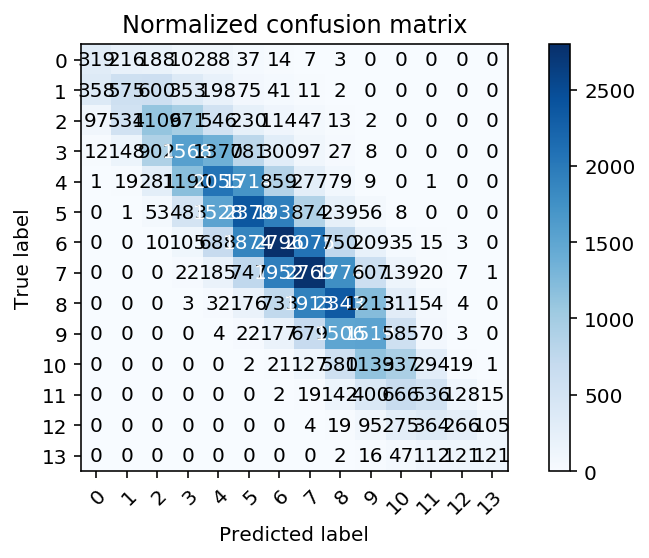

<Figure size 72x72 with 0 Axes>

In [80]:
plot_confusion_matrix(y_ts, y_pred, classes=range(0,14),
                      title='Normalized confusion matrix')
plt.show()
